# Polynom n-ten Grades

Wie gross ist der Einfluss der Polynomwahl auf die Ergebnisse? Um diese Frage zu beantworten, führen wir die Datenauswertung mit unterschiedlichen Annahmen durch und vergleichen dann die Ergebnisse. Wir können irgendwelche Daten verwenden, soweit einigermassen realistisch, um das Prinzip zu testen. Folgende Daten sollen sinnvolle Ergebnisse liefern:

*   **Plaxis 2D:** linke Spundwand Phase 3 (Plaxis-Datei: Schnitt_7_Geologie.p2dx, Stand 29.11.2023). Die Simulation erfolgte mit einem Abminderungsfaktor $\beta_D = 0.7$
*   **Inklino:** Rohr I-52N, Verformung in Richtung A, Datum 21 April 2020.

In diesem Skript verwenden folgende Annahmen:

*   für den Moment verwenden wir ein **Polynom 7. Grades**, und
*   für den Inklinometer ein **Polynom 9. Grades**.

In [ ]:
#test_flag_colab
from google.colab import drive
drive.mount('/content/drive')

# working directory: drive/MyDrive/spundsteif
%cd '/content/drive/MyDrive/spundsteif'

%load_ext autoreload
%autoreload 2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/spundsteif


In [ ]:
import pandas as pd
import numpy as np
import io
import csv
import re
from datetime import datetime, date

from google.colab import files

from copy import copy

from datetime import timedelta
from datetime import datetime

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Daten importieren

## Plaxis file: Schnitt_7_Geologie

In [ ]:
# Plaxis displacement data
# Plaxis file: Schnitt_7_Geologie
# 07 means betaD=0.7
df_plaxis_07_geol = pd.read_csv('./data/ux_Phase_3_07_geol.csv', delimiter=';')
df_plaxis_07_geol

,Y_coordinate_[m]_07,ux_Phase_3_[m]_07
0,1.00,-0.010800
1,0.95,-0.010100
2,0.90,-0.009410
3,0.85,-0.008730
4,0.80,-0.008050
...,...,...
88,-14.90,-0.000674
89,-15.20,-0.000816
90,-15.40,-0.000942
91,-15.70,-0.001060


In [ ]:
# Plaxis moment data
# Plaxis file: Schnitt_7_Geologie
df_plaxis_M = pd.read_csv('./data/M_Phase_3_07_geol.csv', delimiter=';')
df_plaxis_M

,Y_coordinate_[m]_07,M_Phase_3_[kNm/m]_07
0,1.00,-4.040000e-14
1,0.95,-1.990000e-14
2,0.90,-4.930000e-14
3,0.85,-3.470000e-14
4,0.80,1.670000e-14
...,...,...
88,-14.90,-2.910000e+01
89,-15.20,-2.190000e+01
90,-15.40,-1.260000e+01
91,-15.70,-4.170000e+00


## Inklinometer Messungen I-52N

In [ ]:
df_inklino_20200401 = pd.read_csv('./data/df_test_20200401.csv', delimiter=',')
#df_inklino_20200401

In [ ]:
df_inklino = df_inklino_20200401.copy()
useless_cols = ['A+',	'A-',	'A_average', 'A_rotation',	'B+',	'B-',	'B_average',	'B_rotation',	'A_defo',	'B_defo']
df_inklino = df_inklino.drop(columns=useless_cols, axis=1)
df_inklino.head(5)

,date,depth,tube,A_defo_relat,B_defo_relat
0,2020-04-01,0.5,I-52N,0.011706,0.005562
1,2020-04-01,1.0,I-52N,0.017093,0.004920
2,2020-04-01,1.5,I-52N,0.022323,0.004362
3,2020-04-01,2.0,I-52N,0.027318,0.003592
4,2020-04-01,2.5,I-52N,0.031903,0.002980


# Direkter Vergleich der lateralen Verschiebungen

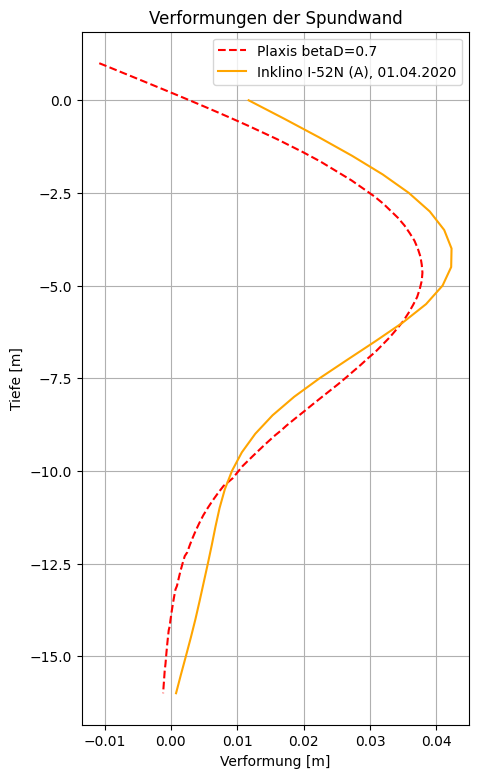

In [ ]:
plt.figure(figsize=(5,9))
plt.title('Verformung der Spundwand')

# Plaxis File: Schnitt_7_Geologie
plt.plot(df_plaxis_07_geol['ux_Phase_3_[m]_07'], df_plaxis_07_geol['Y_coordinate_[m]_07'], color='red', linestyle='--', label='Plaxis betaD=0.7')

# Inclinometer data
plt.plot(df_inklino['A_defo_relat'], -df_inklino['depth']+0.5, color='orange', linestyle='-', label='Inklino I-52N (A), 01.04.2020')

plt.xlabel('Verformung [m]')
plt.ylabel('Tiefe [m]')
plt.grid(visible=True, which='major', axis='both')
plt.legend()
plt.show()

# Qualitatively similar.

# Rückrechnung basierend auf den Momenten aus Plaxis

## Vorbereiten der Inklinometerdaten

In [ ]:
# Fit a polynom of 9th degree to the displacements (inclinometer data).
# We consider the lateral displacement (direction A).
# Save the coefficients in a dataframe.

sheet_piles = ['Wylerfeld piles']
coefficients = ['a9', 'a8', 'a7', 'a6', 'a5', 'a4', 'a3', 'a2', 'a1', 'a0']
displacement = ['direction A']

my_index = pd.MultiIndex.from_product([sheet_piles, displacement], names=['sheet_piles', 'displacement'])
df_coeff_inclino = pd.DataFrame(np.zeros([1, 10]), index=my_index, columns = coefficients)

#df_coeff_inclino

In [ ]:
df_coeff_inclino.loc[('Wylerfeld piles', 'direction A'), :] = np.polyfit(df_inklino['depth'], df_inklino['A_defo_relat'], 9)

df_coeff_inclino

,,a9,a8,a7,a6,a5,a4,a3,a2,a1,a0
sheet_piles,displacement,,,,,,,,,,
Wylerfeld piles,direction A,1.312554e-11,-5.727247e-09,3.626574e-07,-0.00001,0.000138,-0.001032,0.003899,-0.00799,0.018285,0.004032


In [ ]:
Y_coord = pd.Series(np.arange(0, -16.25, -0.25))  # y-coordinate [m] as in the Plaxis model
df_fit_inclino = pd.DataFrame(data = Y_coord, columns=['Y_coord'])
df_fit_inclino['depth'] = -Y_coord + 0.5                    # inclinometer depth


# w indicates displacement
# w1 indicates slope, the first derivative of w
# w2 indicates curvature, the second derivative of w


# calculate fitted values
df_fit_inclino['w_Wyler_A'] = np.polyval(df_coeff_inclino.loc[('Wylerfeld piles', 'direction A'), :], df_fit_inclino['depth'])

df_fit_inclino

,Y_coord,depth,w_Wyler_A
0,0.00,0.50,0.011604
1,-0.25,0.75,0.014601
2,-0.50,1.00,0.017322
3,-0.75,1.25,0.019884
4,-1.00,1.50,0.022358
...,...,...,...
60,-15.00,15.50,0.002280
61,-15.25,15.75,0.002005
62,-15.50,16.00,0.001694
63,-15.75,16.25,0.001286


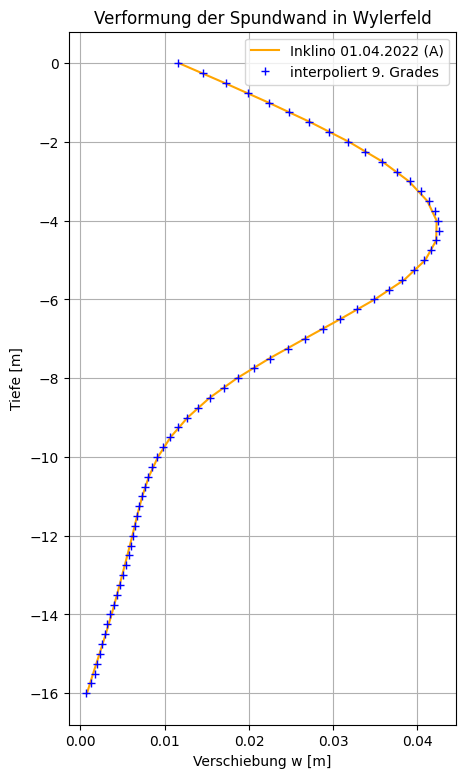

In [ ]:
plt.figure(figsize=(5,9))
plt.title('Verformung der Spundwand in Wylerfeld')

plt.plot(df_inklino['A_defo_relat'], -df_inklino['depth']+0.5, color='orange', linestyle='-', label='Inklino 01.04.2022 (A)')
plt.plot(df_fit_inclino['w_Wyler_A'], df_fit_inclino['Y_coord'], 'b+', label = 'interpoliert 9. Grades')

plt.grid(visible=True, which='major', axis='both')
plt.xlabel('Verschiebung w [m]')
plt.ylabel('Tiefe [m]')
plt.legend()
plt.show()

In [ ]:
# w indicates displacement
# w1 indicates slope, the first derivative of w
# w2 indicates curvature, the second derivative of w


# w1
for index, row in df_fit_inclino.iterrows():
  if index == 0 or index == 64:
    df_fit_inclino.at[index, 'w1_Wyler_A'] = np.nan
  else:
    df_fit_inclino.at[index, 'w1_Wyler_A'] = (df_fit_inclino.at[(index+1), 'w_Wyler_A'] - df_fit_inclino.at[(index-1), 'w_Wyler_A']) / (df_fit_inclino.at[(index+1), 'Y_coord'] - df_fit_inclino.at[(index-1), 'Y_coord'])


# w2
for index, row in df_fit_inclino.iterrows():
  if index <= 1 or index >= 63:
    df_fit_inclino.at[index, 'w2_Wyler_A'] = np.nan
  else:
    df_fit_inclino.at[index, 'w2_Wyler_A'] = (df_fit_inclino.at[(index+1), 'w1_Wyler_A'] - df_fit_inclino.at[(index-1), 'w1_Wyler_A']) / (df_fit_inclino.at[(index+1), 'Y_coord'] - df_fit_inclino.at[(index-1), 'Y_coord'])


#df_fit_inclino

## Vorbereiten der Momenten aus Plaxis

Der Momentenverlauf in den VL607 Profilen wurde mit Plaxis 2D berechnet. Um eine solche Simulation durchzuführen, muss der Anwender einen Wert der Steifigkeit eingeben, welcher den Abimnderungsfaktor $\beta_D$ berücksichtigt. Die vorliegende Plaxis-Simulation wurde mit $\beta_D = 0.7$ durchgeführt.

In diesem Skript wurde der Momentenverlauf mit einem **Polynom 7. Grades** interpoliert.

In [ ]:
# Fit a polynom of 7th degree to the moments (obtained from Plaxis).
# Save the coefficients in a dataframe.

coefficients = ['a7', 'a6', 'a5', 'a4', 'a3', 'a2', 'a1', 'a0']
reduction_factor = ['beta_07'] # 07 means betaD=0.7
df_coeff_moment = pd.DataFrame(np.zeros([1, 8]), index=reduction_factor, columns = coefficients)

#df_coeff_moment

In [ ]:
df_coeff_moment.loc['beta_07', :] = np.polyfit(df_plaxis_M['Y_coordinate_[m]_07'], df_plaxis_M['M_Phase_3_[kNm/m]_07'], 7)
df_coeff_moment

,a7,a6,a5,a4,a3,a2,a1,a0
beta_07,-0.000442,-0.02231,-0.403041,-2.976351,-7.259585,-14.911815,-128.704035,125.935714


In [ ]:
# Let's construct a multi-index dataframe where we are going to save all of our calculation results.

reduction_factor = ['beta_07']   # this is the reduction factor used in the Plaxis simulation
Y_coord = Y_coord
back_calculation = ['moment_M', 'stiffness_EI', 'beta'] # we aim at back calculationg beta

my_index = pd.MultiIndex.from_product([reduction_factor, back_calculation], names=['reduction factor', 'back calculation'])

df_BC = pd.DataFrame(np.zeros([3, 65]), index=my_index, columns = Y_coord)  # BC means back calculation
df_BC = df_BC.T
df_BC

reduction factor  beta_07                  
back calculation moment_M stiffness_EI beta
 0.00                 0.0          0.0  0.0
-0.25                 0.0          0.0  0.0
-0.50                 0.0          0.0  0.0
-0.75                 0.0          0.0  0.0
-1.00                 0.0          0.0  0.0
...                   ...          ...  ...
-15.00                0.0          0.0  0.0
-15.25                0.0          0.0  0.0
-15.50                0.0          0.0  0.0
-15.75                0.0          0.0  0.0
-16.00                0.0          0.0  0.0

[65 rows x 3 columns]

In [ ]:
# interpolation of the moment obtained with Plaxis 2D by a polynomial

df_BC.loc[:, ('beta_07', 'moment_M')] = np.polyval(df_coeff_moment.loc['beta_07', :], Y_coord)

#df_BC

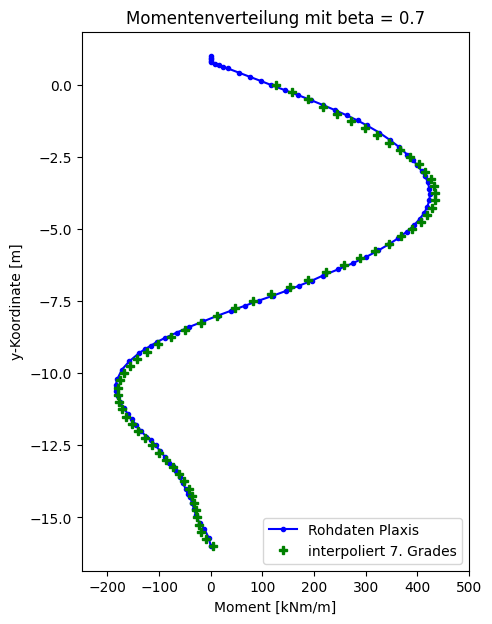

In [ ]:
# compare the interpolated moment with the rawdata from Plaxis 2D

plt.figure(figsize=(5,7))

plt.title('Momentenverteilung mit betaD = 0.7')
plt.plot(df_plaxis_M['M_Phase_3_[kNm/m]_07'], df_plaxis_M['Y_coordinate_[m]_07'], 'b.-', label = 'Rohdaten Plaxis')
plt.plot(df_BC[('beta_07', 'moment_M')], df_fit_inclino['Y_coord'], 'gP', label = 'interpoliert 7. Grades')

plt.xlim(-250, 500)
plt.xlabel('Moment [kNm/m]')
plt.ylabel('y-Koordinate [m]')
plt.legend()

plt.show()

## Ergebnis

In [ ]:
# Let's back calculate the reduction factor beta.

# stiffness for a continuous sheet pile wall of VL607-profiles, according to Stabau GmbH, in [kNm2/m]
EI_continuous = 153930

# the two dataframes work with different indeces:
# df_BC: 0.00, -0.25, -0.50, ...
# df_fit_inclino: 0, 1, 2, ...
i = 0

for index, row in df_BC.iterrows():
  # EI = -M / w2
  df_BC.at[index, ('beta_07', 'stiffness_EI')] = -df_BC.at[index, ('beta_07', 'moment_M')] / df_fit_inclino.at[i, 'w2_Wyler_A']

  # beta = EI / EI_continuous
  df_BC.at[index, ('beta_07', 'beta')] = df_BC.at[index, ('beta_07', 'stiffness_EI')] / EI_continuous

  i += 1

df_BC

reduction factor     beta_07                        
back calculation    moment_M  stiffness_EI      beta
 0.00             125.935714           NaN       NaN
-0.25             157.281927           NaN       NaN
-0.50             187.293454  6.861263e+04  0.445739
-0.75             216.288478  1.387997e+05  0.901707
-1.00             244.392341  2.552370e+05  1.658137
...                      ...           ...       ...
-15.00            -25.967998 -1.144448e+06 -7.434861
-15.25            -22.890114 -3.475959e+04 -0.225814
-15.50            -18.045800 -1.068802e+04 -0.069434
-15.75             -9.584816           NaN       NaN
-16.00              4.856000           NaN       NaN

[65 rows x 3 columns]

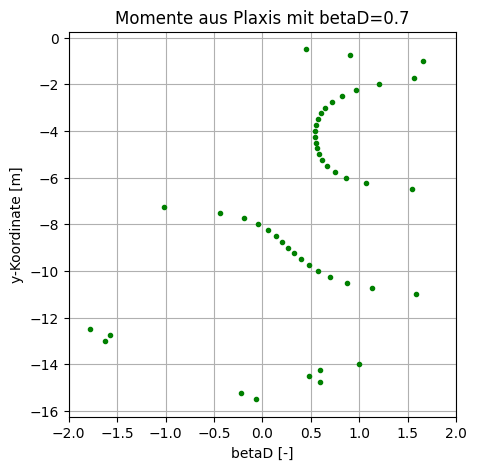

In [ ]:
# Let's plot the reduction factor beta.

plt.figure(figsize=(5,5))

plt.title('Momente aus Plaxis mit betaD=0.7')
plt.plot(df_BC[('beta_07', 'beta')], df_fit_inclino['Y_coord'], 'g.', label = 'beta')
plt.xlim(-2, 2)
plt.grid(visible=True, which='major', axis='both')
plt.xlabel('betaD [-]')
plt.ylabel('y-Koordinate [m]')

plt.show()

In [ ]:
# Calculate the average beta at a given depth.
# Between 2.5 m and 6 m the values for beta are stable.

beta_7_9 = round(df_BC.loc[-2.5:-6 , ('beta_07', 'beta')].mean(), 3)
beta_7_9

0.639